In [251]:
import numpy as np
import pandas as pd
import pylab as pl
from matplotlib.dates import MonthLocator
from sklearn import tree
from sklearn.ensemble.forest import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

filename_test = 'test.csv'
filename_train = 'train.csv'
filename_store = 'store.csv'

train = pd.read_csv(filename_train, header=0, low_memory=False)

test = pd.read_csv(filename_test, header=0, low_memory=False)


store_info = pd.read_csv(filename_store, header=0, low_memory=False)



In [252]:
train.Date = pd.to_datetime(train.Date)

test.Date = pd.to_datetime(test.Date)


In [253]:
def print_missing_stats():
    for data_name, data in {'TRAIN': train, 'TEST': test, 'STORE': store_info}.items():
        print(data_name, ' (overall = %d)' % len(data))
        for attribute in data.columns:
            mask = data[attribute].isnull()
            k = len(data[attribute][mask].tolist())
            print('%5d (%2d%%)' % (k, 100*k/len(data)), 'missing values in ', attribute) 
        print()
print_missing_stats()

TEST  (overall = 41088)
    0 ( 0%) missing values in  Id
    0 ( 0%) missing values in  Store
    0 ( 0%) missing values in  DayOfWeek
    0 ( 0%) missing values in  Date
   11 ( 0%) missing values in  Open
    0 ( 0%) missing values in  Promo
    0 ( 0%) missing values in  StateHoliday
    0 ( 0%) missing values in  SchoolHoliday

TRAIN  (overall = 1017209)
    0 ( 0%) missing values in  Store
    0 ( 0%) missing values in  DayOfWeek
    0 ( 0%) missing values in  Date
    0 ( 0%) missing values in  Sales
    0 ( 0%) missing values in  Customers
    0 ( 0%) missing values in  Open
    0 ( 0%) missing values in  Promo
    0 ( 0%) missing values in  StateHoliday
    0 ( 0%) missing values in  SchoolHoliday

STORE  (overall = 1115)
    0 ( 0%) missing values in  Store
    0 ( 0%) missing values in  StoreType
    0 ( 0%) missing values in  Assortment
    3 ( 0%) missing values in  CompetitionDistance
  354 (31%) missing values in  CompetitionOpenSinceMonth
  354 (31%) missing values in  

### Filling missing values

In [254]:
# print(test[test.Open.isnull()])
test.ix[test.Open.isnull(), 'Open'] = 1

store_info.ix[store_info.CompetitionDistance.isnull(),
         'CompetitionDistance'] = store_info.CompetitionDistance.mean()
store_info.ix[store_info.CompetitionOpenSinceMonth.isnull(),
         'CompetitionOpenSinceMonth'] = int(store_info.CompetitionOpenSinceMonth.mode())
store_info.ix[store_info.CompetitionOpenSinceYear.isnull(),
         'CompetitionOpenSinceYear'] = int(store_info.CompetitionOpenSinceYear.mode())

print_missing_stats()

TEST  (overall = 41088)
    0 ( 0%) missing values in  Id
    0 ( 0%) missing values in  Store
    0 ( 0%) missing values in  DayOfWeek
    0 ( 0%) missing values in  Date
    0 ( 0%) missing values in  Open
    0 ( 0%) missing values in  Promo
    0 ( 0%) missing values in  StateHoliday
    0 ( 0%) missing values in  SchoolHoliday

TRAIN  (overall = 1017209)
    0 ( 0%) missing values in  Store
    0 ( 0%) missing values in  DayOfWeek
    0 ( 0%) missing values in  Date
    0 ( 0%) missing values in  Sales
    0 ( 0%) missing values in  Customers
    0 ( 0%) missing values in  Open
    0 ( 0%) missing values in  Promo
    0 ( 0%) missing values in  StateHoliday
    0 ( 0%) missing values in  SchoolHoliday

STORE  (overall = 1115)
    0 ( 0%) missing values in  Store
    0 ( 0%) missing values in  StoreType
    0 ( 0%) missing values in  Assortment
    0 ( 0%) missing values in  CompetitionDistance
    0 ( 0%) missing values in  CompetitionOpenSinceMonth
    0 ( 0%) missing values in  

### Plotting all sales by day of week and store

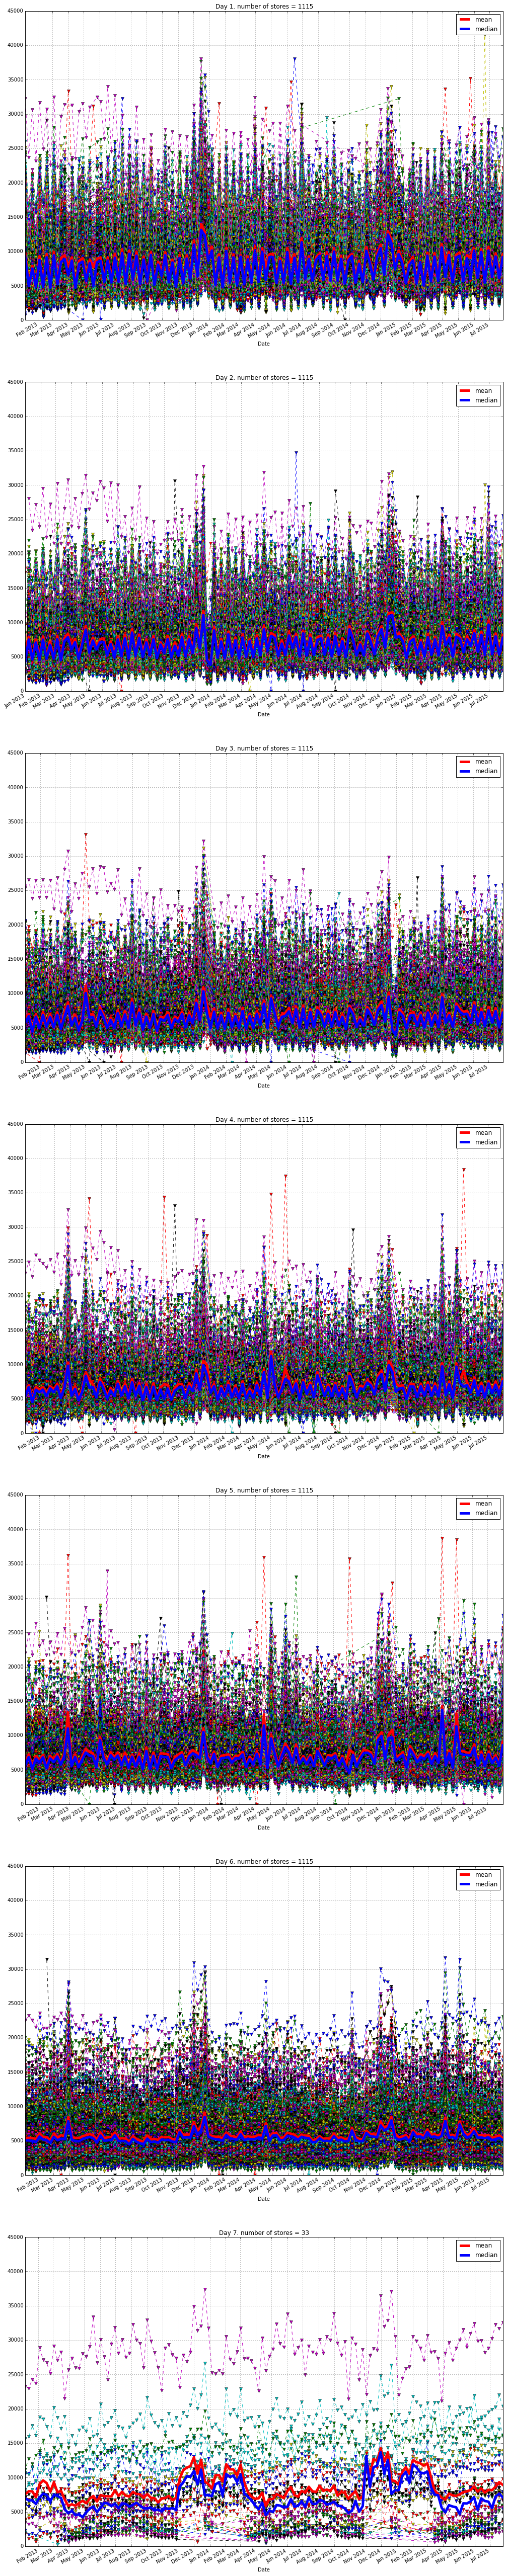

In [255]:
fig, axes = pl.subplots(nrows=7, ncols=1, sharey=True, figsize=(17,100))

for day_of_week in range(1, 8):
    custom_df = train[(train['Open'] == 1) & (train['DayOfWeek'] == day_of_week)]
    gp_store = custom_df.groupby('Store')

    for store, group in gp_store:
        axes[day_of_week - 1].plot(group['Date'], group['Sales'], 'v--')

    gp_date = custom_df.groupby('Date')

    ts_mean = gp_date['Sales'].mean()
    ts_median = gp_date['Sales'].median()
    ts_mean.plot(style='r-', linewidth=5, ax=axes[day_of_week - 1], label='mean')
    ts_median.plot(style='b-', linewidth=5, ax=axes[day_of_week - 1], label='median')


    axes[day_of_week - 1].set_title('Day ' + str(day_of_week) + '. number of stores = ' + str(len(gp_store)))
    axes[day_of_week - 1].legend()
    axes[day_of_week - 1].xaxis.set_major_locator(MonthLocator())
    axes[day_of_week - 1].grid(True)
# pl.savefig('all_stores_and_median.png', format='png')
del fig
del axes

### Plotting mean of sales by day of week with different values of categorical features

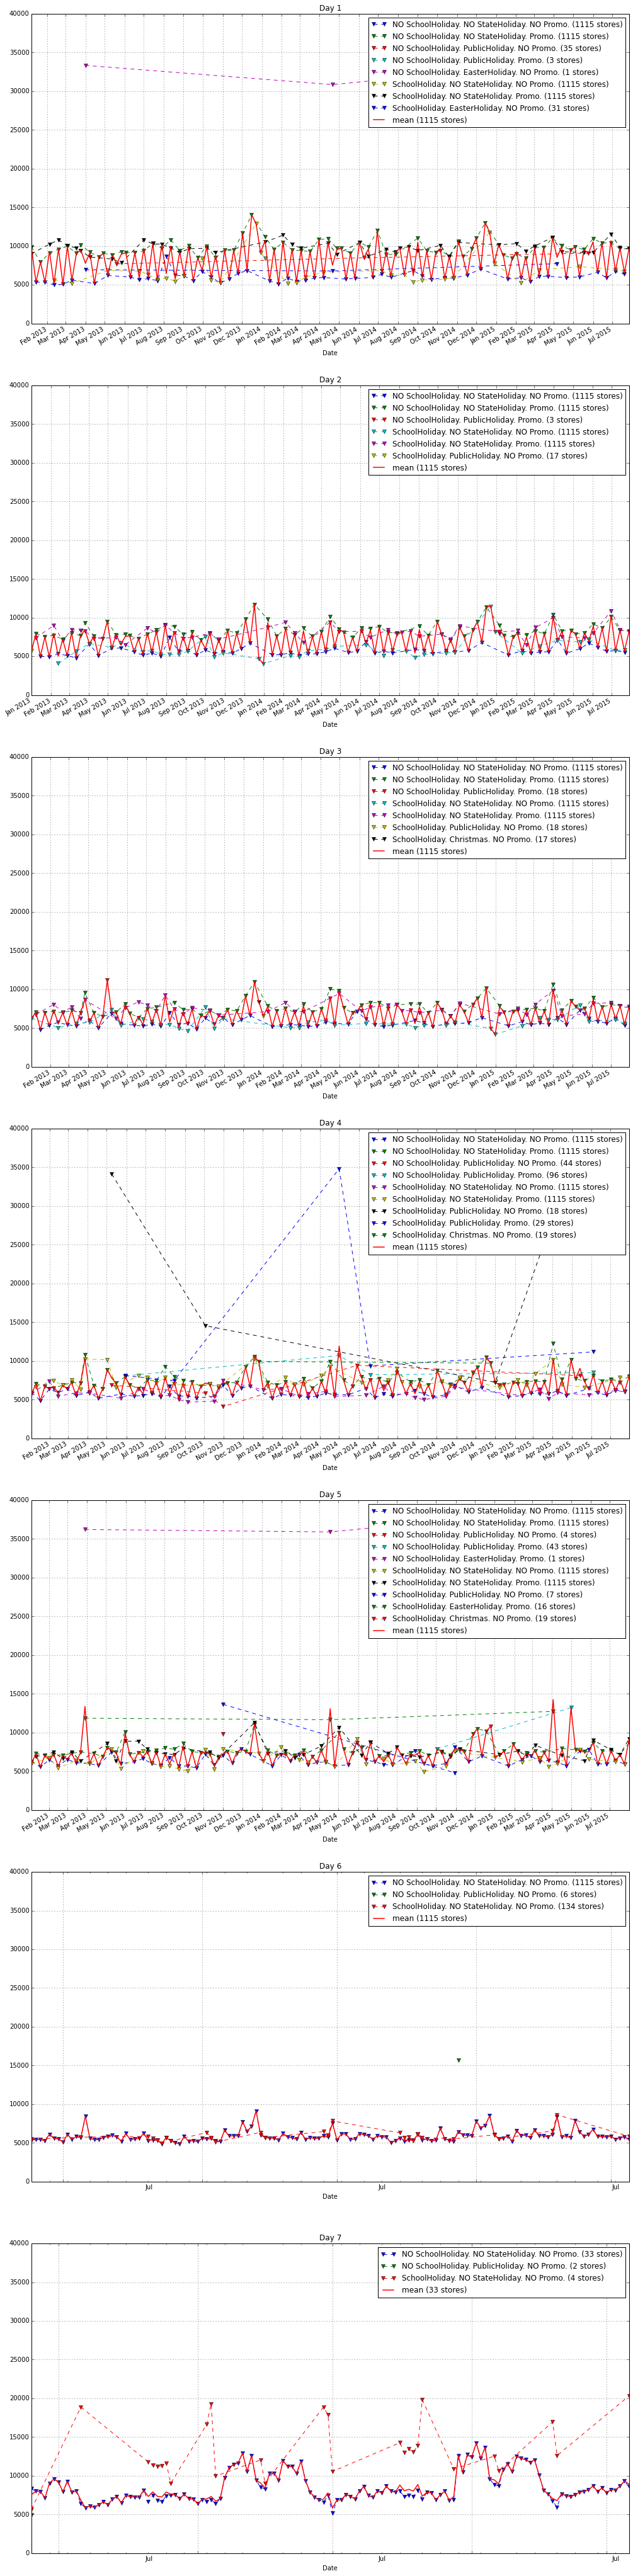

In [256]:
def construct_label_name(school_holiday, state_holiday, promo_flag, n_stores):
    string_school = 'NO SchoolHoliday. '
    string_state = 'NO StateHoliday. '
    string_promo = 'NO Promo. '
    if school_holiday == 1:
        string_school = string_school[3:]
    if promo_flag:
        string_promo = string_promo[3:]
    if state_holiday != '0':
        string_state = {'a': 'PublicHoliday. ',
                        'b': 'EasterHoliday. ',
                        'c':'Christmas. '}[state_holiday]
    string_stores = '(' + str(n_stores) + ' stores)'
    return string_school + string_state + string_promo + string_stores

fig, axes = pl.subplots(nrows=7, ncols=1, sharey=True, figsize=(17,80))
for day_of_week in range(1, 8):
    for school_holiday in [0, 1]:
        for state_holiday in ['0', 'a', 'b', 'c']:
            for promo_flag in [0, 1]:
                custom_df = train[(train.Open == 1) & 
                                  (train.DayOfWeek == day_of_week) &
                                  (train.Promo == promo_flag) & 
                                  (train.SchoolHoliday == school_holiday) & 
                                  (train.StateHoliday == state_holiday)]

                gp_date = custom_df.groupby('Date')
                gp_store = custom_df.groupby('Store')
                
                if list(gp_date.Sales):
                    ts_mean = gp_date.Sales.mean()
                    ts_mean.plot(style='v--', ax=axes[day_of_week - 1], 
                                 label=construct_label_name(school_holiday, state_holiday,
                                                            promo_flag, len(gp_store)))
    
                
    custom_df = train[(train.Open == 1) & (train.DayOfWeek == day_of_week)]
    gp_date = custom_df.groupby('Date')
    gp_store = custom_df.groupby('Store')
    ts_mean = gp_date.Sales.mean()
    ts_mean.plot(style='r-', linewidth=1.5, ax=axes[day_of_week - 1],
                 label='mean (' + str(len(gp_store)) + ' stores)')
    axes[day_of_week - 1].set_title('Day ' + str(day_of_week))
    axes[day_of_week - 1].legend()
    axes[day_of_week - 1].xaxis.set_major_locator(MonthLocator())
    axes[day_of_week - 1].grid(True)
    
    
# pl.savefig('median_decomposition.png', format='png')
del fig
del axes

### Constructing train data

In [257]:
data_train, data_train_labels, data_test = [], [], []

date_range_train = pd.date_range('2013-01-01', '2014-12-31')
date_range_test = pd.date_range('2015-01-01', '2015-12-31')

validation = True
stores_numbers = range(1, 1116)
# stores_numbers = np.random.randint(1115, size=20) + 1

train_date_range = train
if validation:
    train_date_range = train[train.Date.isin(date_range_train)]

for store in stores_numbers:    
#     print(store, end=' ')
    custom_store_df = train_date_range[train_date_range.Store == store]
    custom_store_info_df = store_info[store_info.Store == store]
    for day_of_week in range(1, 8):
        custom_store_week_df = custom_store_df[(custom_store_df.DayOfWeek == day_of_week)]
        for promo in [0, 1]:
            df_promo = custom_store_week_df[custom_store_week_df.Promo == promo]
            for school_holiday in [0, 1]:
                df = df_promo[df_promo.SchoolHoliday == school_holiday]
                for state_holiday in ['0', 'a', 'b', 'c']:
                    if not df.empty:
                        m = df.Sales.median()
                        data_train.append([store, day_of_week, promo, state_holiday,
                                           custom_store_info_df.StoreType.iloc[0],
                                           custom_store_info_df.Assortment.iloc[0], school_holiday])
#                         data_train.append([store, day_of_week, promo, state_holiday])
                        data_train_labels.append(m)

print('\nConstructed data_train')
data_train = np.asarray(data_train)
holiday_encoder = LabelEncoder()
storetype_encoder = LabelEncoder()
assortment_encoder = LabelEncoder()
holiday_encoder.fit(['0', 'a', 'b', 'c'])
storetype_encoder.fit(['a', 'b', 'c', 'd'])
assortment_encoder.fit(['a', 'b', 'c'])
data_train[:, 3] = holiday_encoder.transform(data_train[:, 3])
data_train[:, 4] = storetype_encoder.transform(data_train[:, 4])
data_train[:, 5] = assortment_encoder.transform(data_train[:, 5])
print('Encoded categorical type')


Constructed data_train
Encoded categorical type


### Constructing test data

In [258]:
features = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'StoreType', 'Assortment', 'SchoolHoliday']
def construct_test(test, holiday_encoder, storetype_encoder, assortment_encoder):
    temp = pd.merge(test, store_info, on='Store', how='left') 
    temp = temp[features]
    temp = np.asarray(temp)
    temp[:, 3] = holiday_encoder.transform(temp[:, 3])
    temp[:, 4] = storetype_encoder.transform(temp[:, 4])
    temp[:, 5] = assortment_encoder.transform(temp[:, 5])
    return temp

if validation:
    local_test = train[(train.Date.isin(date_range_test)) & (train.Store.isin(stores_numbers))]
    local_test_labels = np.asarray(local_test.Sales)
    local_test = construct_test(local_test, holiday_encoder, storetype_encoder, assortment_encoder)
else:
    data_test = construct_test(test, holiday_encoder, storetype_encoder, assortment_encoder)

### Predicting

('Store', 0.52607291986368399) ('DayOfWeek', 0.27257251065257437) ('Promo', 0.12925379519832006) ('StateHoliday', 0.0) ('StoreType', 0.048424960973560652) ('Assortment', 0.018544714692359032) ('SchoolHoliday', 0.0051310986195018723)
RMSPE = 76.5193947539


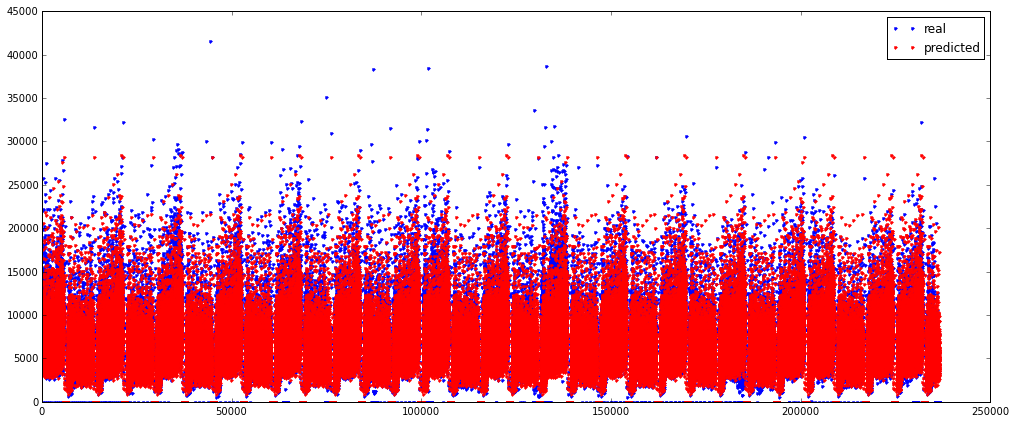

In [259]:
# from sklearn.externals.six import StringIO  
# import pydot

clf = tree.DecisionTreeRegressor()

clf.fit(data_train, data_train_labels)
print(*zip(features, clf.feature_importances_))
# tree.export_graphviz(clf, out_file='decision.dot')
# graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
# graph.write_pdf("decision.pdf") 

def compute_RMSPE(test_labels, predicted_labels):
        mask = test_labels.nonzero()
        y = test_labels[mask]
        y_hat = predicted_labels[mask]
        return np.sqrt()

if validation:
    predicted_test_labels = np.asarray(clf.predict(local_test), dtype=int) #CAUTION!
    loss_score = compute_RMSPE(local_test_labels, predicted_test_labels)
    print('RMSPE =', loss_score)
    pl.figure(figsize=(17,7))
    pl.plot(local_test_labels, 'b.', label='real')
    pl.plot(predicted_test_labels, 'r.', label='predicted')
    pl.legend()
    
else:
    data_test_labels = np.asarray(clf.predict(data_test), dtype=int) 
    test['Sales'] = data_test_labels
    test[['Id', 'Sales']].to_csv('prediction.csv', index=False)
    print('\nresult was written to prediction.csv')

### Plotting prediction (mean and median by stores) by day of week

In [260]:
if not validation:
    fig, axes = pl.subplots(nrows=7, ncols=1, sharey=True, figsize=(17,100))
    
    train_open = train[train.Open == 1]
    test_open = test[test.Open == 1]
    for day_of_week in range(1, 8):
        custom_df = train_open[train_open.DayOfWeek == day_of_week]
        gp_date = custom_df.groupby('Date')

        ts_mean = gp_date.Sales.mean()
        ts_mean.plot(style='r-', linewidth=2, ax=axes[day_of_week - 1], label='mean')
        ts_median = gp_date.Sales.median()
        ts_median.plot(style='b-', linewidth=2, ax=axes[day_of_week - 1], label='median')
        

        custom_df = test_open[test_open.DayOfWeek == day_of_week]
        gp_date = custom_df.groupby('Date')

        ts_mean = gp_date.Sales.mean()
        ts_mean.plot(style='k--', linewidth=2, ax=axes[day_of_week - 1], label='mean predicted')
        ts_median = gp_date.Sales.median()
        ts_median.plot(style='y--', linewidth=2, ax=axes[day_of_week - 1], label='median predicted')


        axes[day_of_week - 1].xaxis.set_major_locator(MonthLocator())
        axes[day_of_week - 1].set_title('Day ' + str(day_of_week))
        axes[day_of_week - 1].legend()
        axes[day_of_week - 1].grid(True)

    del fig
    del axes